In [1]:
import os
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox
from scipy.stats import boxcox, shapiro
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.preprocessing import BoxCoxEndogTransformer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Get Data

In [2]:
path = kagglehub.dataset_download("vikramamin/arima-time-series-mumbai-temperature")
print("Path to dataset files:", path)

Path to dataset files: /Users/carlosmayorga/.cache/kagglehub/datasets/vikramamin/arima-time-series-mumbai-temperature/versions/1


In [3]:
print(os.listdir(path))

['rainfall.csv']


In [4]:
file_path = os.path.join(path, "rainfall.csv")  # adjust name if needed
data = pd.read_csv(file_path)
print(data.info())

<class 'pandas.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          1781 non-null   str    
 1   temp              1781 non-null   float64
 2   dew               1781 non-null   float64
 3   humidity          1781 non-null   float64
 4   sealevelpressure  1781 non-null   float64
 5   winddir           1781 non-null   float64
 6   solarradiation    1781 non-null   float64
 7   windspeed         1781 non-null   float64
 8   precipprob        1781 non-null   int64  
 9   preciptype        1781 non-null   int64  
dtypes: float64(7), int64(2), str(1)
memory usage: 156.7 KB
None


In [5]:
data['date'] = pd.to_datetime(data['datetime'], dayfirst=True)

ts = data.set_index("date")["temp"]
ts = ts.resample("W").mean()
print(ts.info())
print('\n')
print(ts.head());

<class 'pandas.Series'>
DatetimeIndex: 255 entries, 2016-01-03 to 2020-11-15
Freq: W-SUN
Series name: temp
Non-Null Count  Dtype  
--------------  -----  
255 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB
None


date
2016-01-03    26.900000
2016-01-10    26.485714
2016-01-17    24.485714
2016-01-24    24.642857
2016-01-31    25.357143
Freq: W-SUN, Name: temp, dtype: float64


# Descomposición de la Serie

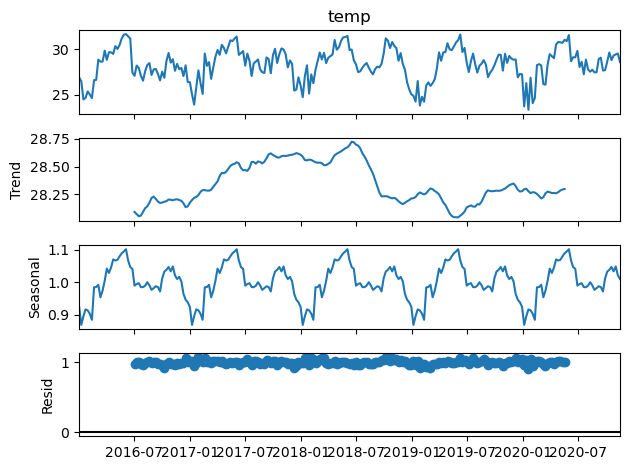

In [6]:
decomp = seasonal_decompose(ts, model="multiplicative", period=52)
decomp.plot();

# Estabilización de la Varianza

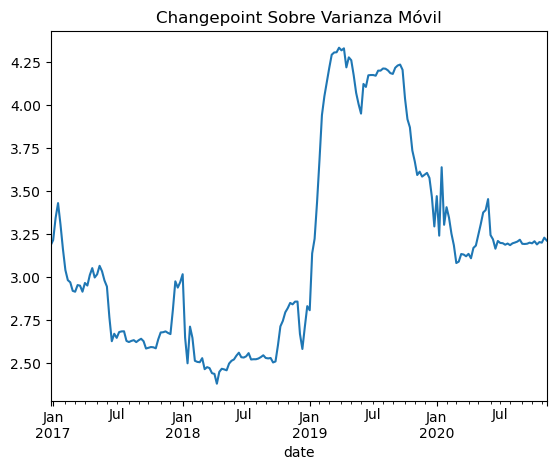

In [7]:
rolling_var = ts.rolling(window=52).var().dropna()
rolling_var.plot().set_title("Changepoint Sobre Varianza Móvil");

In [8]:
def guerrero_lambda(ts, m=52, lambdas=np.linspace(-2, 2, 300)):
    ts = ts.dropna().values
    ts = ts[ts > 0]  # Box–Cox requiere positivos

    blocks = np.array_split(ts, len(ts)//m)
    scores = []

    for lam in lambdas:
        stds = []
        for b in blocks:
            bt = boxcox(b, lam)
            stds.append(np.std(bt, ddof=1))

        stds = np.array(stds)
        score = np.std(np.log(stds)) / np.mean(np.log(stds))
        scores.append(score)

    return lambdas[np.argmin(scores)]

lam = guerrero_lambda(ts, m=52)
print('Lambda que minimiza CV (Gerrero): ' + lam.astype(str))


Lambda que minimiza CV (Gerrero): 0.8227424749163879


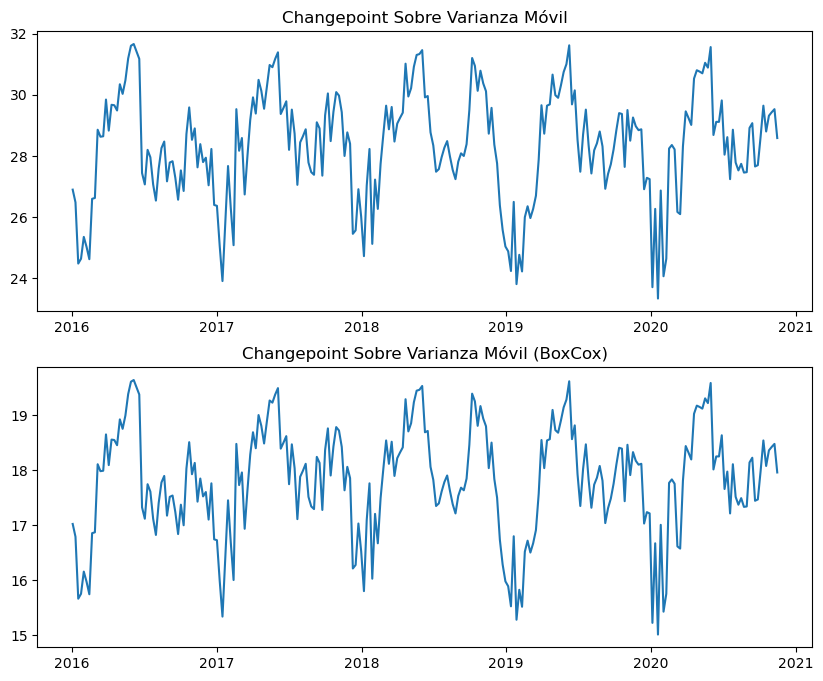

In [9]:
ts_bc = boxcox(ts, lam)
ts_bc = pd.Series(ts_bc, index=ts.index)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(ts); axes[0].set_title("Changepoint Sobre Varianza Móvil")
axes[1].plot(ts_bc); axes[1].set_title("Changepoint Sobre Varianza Móvil (BoxCox)");

# Estabilización de la Media

Best d = 1, Best D = 0


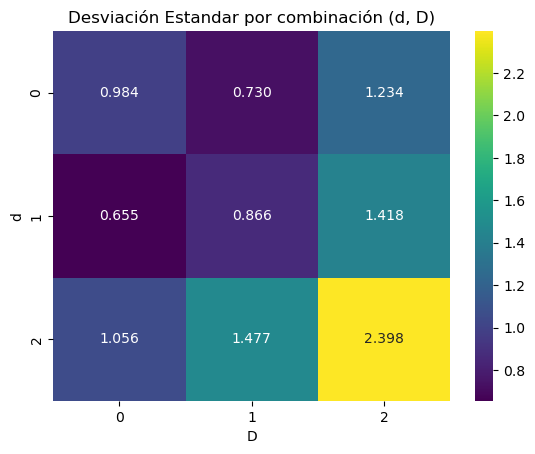

In [10]:
def difference_series(ts, d=0, D=0, s=52):
    ts_diff = ts.copy()

    for _ in range(d):
        ts_diff = ts_diff.diff()

    for _ in range(D):
        ts_diff = ts_diff.diff(s)

    return ts_diff.dropna()

def find_best_diff(ts, max_d=2, max_D=2, s=52):
    results = []

    for d in range(max_d + 1):
        for D in range(max_D + 1):
            ts_d = difference_series(ts, d=d, D=D, s=s)
            std = ts_d.std()
            results.append({"d": d, "D": D, "standar deviation": std})

    df_results = pd.DataFrame(results).sort_values("standar deviation")

    best = df_results.loc[df_results["standar deviation"].idxmin()]

    return int(best["d"]), int(best["D"]), df_results

best_d, best_D, df_results = find_best_diff(ts_bc, s=52)
print(f"Best d = {best_d}, Best D = {best_D}")

pivot = df_results.pivot(index="d", columns="D", values="standar deviation")

sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Desviación Estandar por combinación (d, D)")
plt.show()

In [11]:
def apply_differencing(ts, d=0, D=0, s=52):
    ts_diff = ts.copy()

    for _ in range(d):
        ts_diff = ts_diff.diff()

    for _ in range(D):
        ts_diff = ts_diff.diff(s)

    return ts_diff.dropna()

ts_final = apply_differencing(ts_bc, d=best_d, D=best_D, s=52)

## Chequeo de Estacionariedad De Media

In [12]:
def check_stationarity(x, name="serie", alpha=0.05):
    adf = adfuller(x.dropna())
    p_value = adf[1]

    print(f"--- {name} ---")
    print(f"ADF p-value: {p_value:.4f}")

    if p_value < alpha:
        print("La serie ES estacionaria (rechazamos H0 de raíz unitaria)")
    else:
        print("La serie NO es estacionaria (no podemos rechazar H0)")

check_stationarity(ts_final, 'Serie estabilizada en varianza y media')

--- Serie estabilizada en varianza y media ---
ADF p-value: 0.0000
La serie ES estacionaria (rechazamos H0 de raíz unitaria)


# Evolución de la Serie

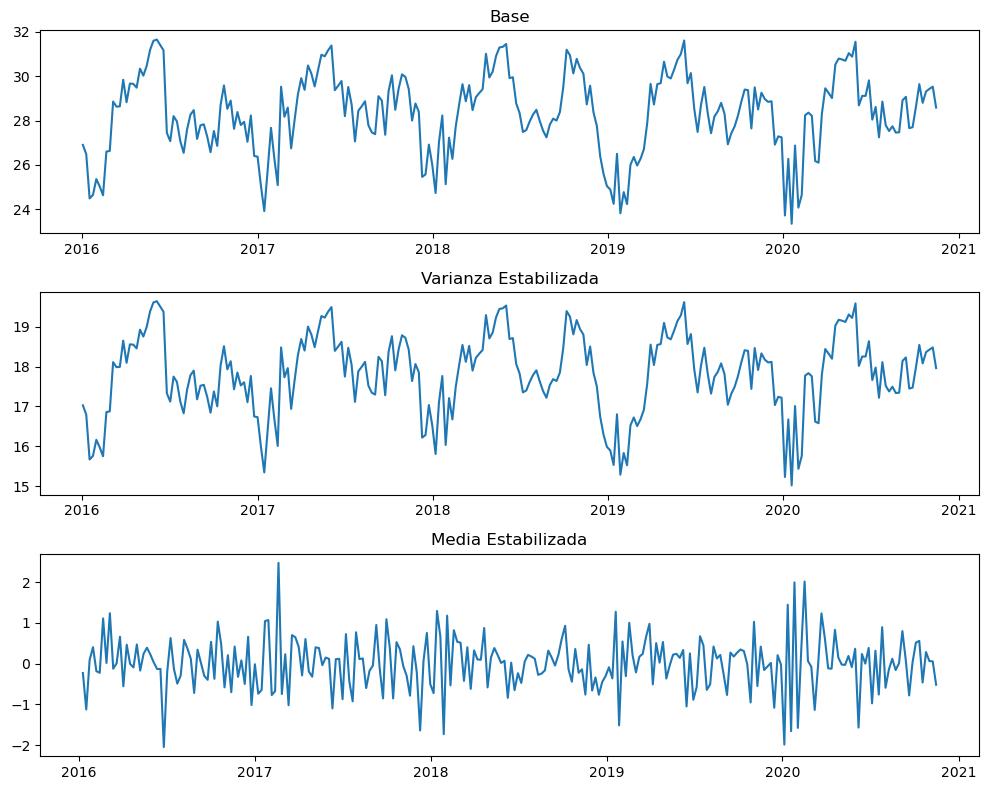

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
axes[0].plot(ts); axes[0].set_title("Base")
axes[1].plot(ts_bc); axes[1].set_title("Varianza Estabilizada")
axes[2].plot(ts_final); axes[2].set_title("Media Estabilizada")
plt.tight_layout()

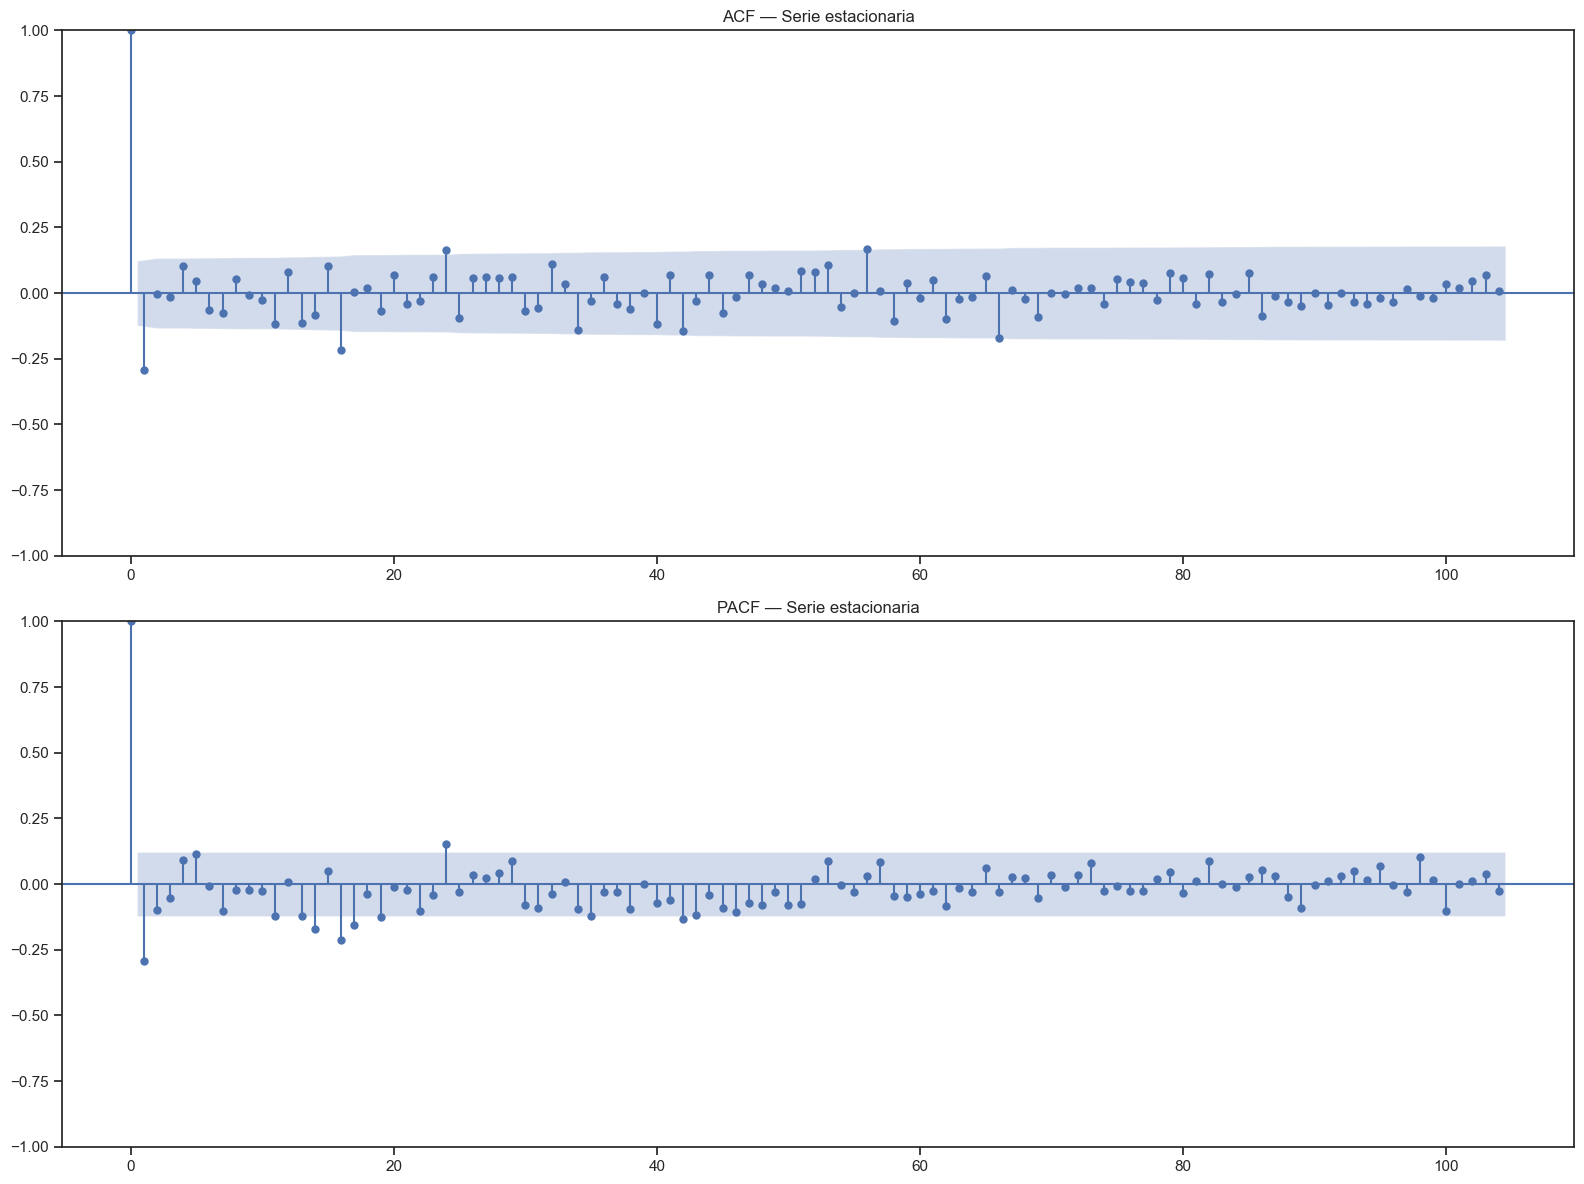

In [14]:
sns.set_theme(style="ticks")

fig, axes = plt.subplots(2, 1, figsize=(16,12))

plot_acf(ts_final, lags=104, ax=axes[0])
axes[0].set_title("ACF — Serie estacionaria")

plot_pacf(ts_final, lags=104, ax=axes[1], method="ywm")
axes[1].set_title("PACF — Serie estacionaria")

plt.tight_layout()
plt.show()

In [57]:
def evaluate_model(ts, order, seasonal_order, name):

    model = SARIMAX(ts,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    results = model.fit(disp=False)
    resid = results.resid.dropna()

    lb_p = acorr_ljungbox(resid, lags=[20], return_df=True)["lb_pvalue"].iloc[0]
    shapiro_p = shapiro(resid.sample(min(len(resid), 500)))[1]

    return {
        "name": name,
        "order": order,
        "seasonal_order": seasonal_order,
        "aic": results.aic,
        "bic": results.bic,
        "lb_p": lb_p,
        "shapiro_p": shapiro_p,
        "results": results
    }

models = []

# models.append(evaluate_model(ts_final, (1,0,0), (0,0,0,52), "SARIMA(1,0,0)(0,0,0)"))
# models.append(evaluate_model(ts_final, (2,0,0), (0,0,0,52), "SARIMA(2,0,0)(0,0,0)"))
# models.append(evaluate_model(ts_final, (0,0,1), (0,0,0,52), "SARIMA(0,0,1)(0,0,0)"))
# models.append(evaluate_model(ts_final, (0,0,2), (0,0,0,52), "SARIMA(0,0,2)(0,0,0)"))
# models.append(evaluate_model(ts_final, (1,0,1), (0,0,0,52), "SARIMA(1,0,1)(0,0,0)"))
# models.append(evaluate_model(ts_final, (2,0,1), (0,0,0,52), "SARIMA(2,0,1)(0,0,0)"))
# models.append(evaluate_model(ts_final, (1,0,2), (0,0,0,52), "SARIMA(1,0,2)(0,0,0)"))

# models.append(evaluate_model(ts_final, (1,0,0), (1,0,0,52), "SARIMA(1,0,0)(1,0,0)"))
# models.append(evaluate_model(ts_final, (2,0,0), (1,0,0,52), "SARIMA(2,0,0)(1,0,0)"))
# models.append(evaluate_model(ts_final, (0,0,1), (1,0,0,52), "SARIMA(0,0,1)(1,0,0)"))
# models.append(evaluate_model(ts_final, (0,0,2), (1,0,0,52), "SARIMA(0,0,2)(1,0,0)"))
# models.append(evaluate_model(ts_final, (1,0,1), (1,0,0,52), "SARIMA(1,0,1)(1,0,0)"))
# models.append(evaluate_model(ts_final, (2,0,1), (1,0,0,52), "SARIMA(2,0,1)(1,0,0)"))
# models.append(evaluate_model(ts_final, (1,0,2), (1,0,0,52), "SARIMA(1,0,2)(1,0,0)"))

# models.append(evaluate_model(ts_final, (1,0,0), (0,0,1,52), "SARIMA(1,0,0)(0,0,1)"))
# models.append(evaluate_model(ts_final, (2,0,0), (0,0,1,52), "SARIMA(2,0,0)(0,0,1)"))
# models.append(evaluate_model(ts_final, (0,0,1), (0,0,1,52), "SARIMA(0,0,1)(0,0,1)"))
# models.append(evaluate_model(ts_final, (0,0,2), (0,0,1,52), "SARIMA(0,0,2)(0,0,1)"))
# models.append(evaluate_model(ts_final, (1,0,1), (0,0,1,52), "SARIMA(2,0,1)(0,0,1)"))
# models.append(evaluate_model(ts_final, (2,0,1), (0,0,1,52), "SARIMA(2,0,1)(0,0,1)"))
# models.append(evaluate_model(ts_final, (1,0,2), (0,0,1,52), "SARIMA(1,0,2)(0,0,1)"))

models.append(evaluate_model(ts_final, (1,0,0), (1,0,1,52), "SARIMA(1,0,0)(1,0,1)"))
models.append(evaluate_model(ts_final, (2,0,0), (1,0,1,52), "SARIMA(2,0,0)(1,0,1)"))
models.append(evaluate_model(ts_final, (0,0,1), (1,0,1,52), "SARIMA(0,0,1)(1,0,1)"))
models.append(evaluate_model(ts_final, (0,0,2), (1,0,1,52), "SARIMA(0,0,2)(1,0,1)"))
models.append(evaluate_model(ts_final, (1,0,1), (1,0,1,52), "SARIMA(1,0,1)(1,0,1)"))
models.append(evaluate_model(ts_final, (2,0,1), (1,0,1,52), "SARIMA(2,0,1)(1,0,1)"))
models.append(evaluate_model(ts_final, (1,0,2), (1,0,1,52), "SARIMA(1,0,2)(1,0,1)"))

# models.append(evaluate_model(ts_final, (1,0,0), (2,0,0,52), "SARIMA(1,0,0)(2,0,0)"))
# models.append(evaluate_model(ts_final, (2,0,0), (2,0,0,52), "SARIMA(2,0,0)(2,0,0)"))
# models.append(evaluate_model(ts_final, (0,0,1), (2,0,0,52), "SARIMA(0,0,1)(2,0,0)"))
# models.append(evaluate_model(ts_final, (0,0,2), (2,0,0,52), "SARIMA(0,0,2)(2,0,0)"))
# models.append(evaluate_model(ts_final, (1,0,1), (2,0,0,52), "SARIMA(1,0,1)(2,0,0)"))
# models.append(evaluate_model(ts_final, (2,0,1), (2,0,0,52), "SARIMA(2,0,1)(2,0,0)"))
# models.append(evaluate_model(ts_final, (1,0,2), (2,0,0,52), "SARIMA(1,0,2)(2,0,0)"))

# models.append(evaluate_model(ts_final, (1,0,0), (0,0,2,52), "SARIMA(1,0,0)(0,0,2)"))
# models.append(evaluate_model(ts_final, (2,0,0), (0,0,2,52), "SARIMA(2,0,0)(0,0,2)"))
# models.append(evaluate_model(ts_final, (0,0,1), (0,0,2,52), "SARIMA(0,0,1)(0,0,2)"))
# models.append(evaluate_model(ts_final, (0,0,2), (0,0,2,52), "SARIMA(0,0,2)(0,0,2)"))
# models.append(evaluate_model(ts_final, (1,0,1), (0,0,2,52), "SARIMA(2,0,1)(0,0,2)"))
# models.append(evaluate_model(ts_final, (2,0,1), (0,0,2,52), "SARIMA(2,0,1)(0,0,2)"))
# models.append(evaluate_model(ts_final, (1,0,2), (0,0,2,52), "SARIMA(1,0,2)(0,0,2)"))

# models.append(evaluate_model(ts_final, (1,0,0), (2,0,1,52), "SARIMA(1,0,0)(2,0,1)"))
# models.append(evaluate_model(ts_final, (2,0,0), (2,0,1,52), "SARIMA(2,0,0)(2,0,1)"))
# models.append(evaluate_model(ts_final, (0,0,1), (2,0,1,52), "SARIMA(0,0,1)(2,0,1)"))
# models.append(evaluate_model(ts_final, (0,0,2), (2,0,1,52), "SARIMA(0,0,2)(2,0,1)"))
# models.append(evaluate_model(ts_final, (1,0,1), (2,0,1,52), "SARIMA(1,0,1)(2,0,1)"))
# models.append(evaluate_model(ts_final, (2,0,1), (2,0,1,52), "SARIMA(2,0,1)(2,0,1)"))
# models.append(evaluate_model(ts_final, (1,0,2), (2,0,1,52), "SARIMA(1,0,2)(2,0,1)"))

# models.append(evaluate_model(ts_final, (1,0,0), (1,0,2,52), "SARIMA(1,0,0)(1,0,2)"))
# models.append(evaluate_model(ts_final, (2,0,0), (1,0,2,52), "SARIMA(2,0,0)(1,0,2)"))
# models.append(evaluate_model(ts_final, (0,0,1), (1,0,2,52), "SARIMA(0,0,1)(1,0,2)"))
# models.append(evaluate_model(ts_final, (0,0,2), (1,0,2,52), "SARIMA(0,0,2)(1,0,2)"))
# models.append(evaluate_model(ts_final, (1,0,1), (1,0,2,52), "SARIMA(1,0,1)(1,0,2)"))
# models.append(evaluate_model(ts_final, (2,0,1), (1,0,2,52), "SARIMA(2,0,1)(1,0,2)"))
# models.append(evaluate_model(ts_final, (1,0,2), (1,0,2,52), "SARIMA(1,0,2)(1,0,2)"))

# models.append(evaluate_model(ts_final, (1,0,0), (2,0,2,52), "SARIMA(1,0,0)(2,0,2)"))
# models.append(evaluate_model(ts_final, (2,0,0), (2,0,2,52), "SARIMA(2,0,0)(2,0,2)"))
# models.append(evaluate_model(ts_final, (0,0,1), (2,0,2,52), "SARIMA(0,0,1)(2,0,2)"))
# models.append(evaluate_model(ts_final, (0,0,2), (2,0,2,52), "SARIMA(0,0,2)(2,0,2)"))
# models.append(evaluate_model(ts_final, (1,0,1), (2,0,2,52), "SARIMA(1,0,1)(2,0,2)"))
# models.append(evaluate_model(ts_final, (2,0,1), (2,0,2,52), "SARIMA(2,0,1)(2,0,2)"))
# models.append(evaluate_model(ts_final, (1,0,2), (2,0,2,52), "SARIMA(1,0,2)(2,0,2)"))

# models.append(evaluate_model(ts_bc, (1,0,0), (1,1,1,52), "SARIMA(1,0,0)(1,1,1)"))
# models.append(evaluate_model(ts_bc, (2,0,0), (1,1,1,52), "SARIMA(2,0,0)(1,1,1)"))
# models.append(evaluate_model(ts_bc, (0,0,1), (1,1,1,52), "SARIMA(0,0,1)(1,1,1)"))
# models.append(evaluate_model(ts_bc, (0,0,2), (1,1,1,52), "SARIMA(0,0,2)(1,1,1)"))
# models.append(evaluate_model(ts_bc, (1,0,1), (1,1,1,52), "SARIMA(1,0,1)(1,1,1)"))
# models.append(evaluate_model(ts_bc, (2,0,1), (1,1,1,52), "SARIMA(2,0,1)(1,1,1)"))
# models.append(evaluate_model(ts_bc, (1,0,2), (1,1,1,52), "SARIMA(1,0,2)(1,1,1)"))

models.append(evaluate_model(ts_bc, (1,1,0), (1,1,1,52), "SARIMA(1,1,0)(1,1,1)"))
models.append(evaluate_model(ts_bc, (2,1,0), (1,1,1,52), "SARIMA(2,1,0)(1,1,1)"))
models.append(evaluate_model(ts_bc, (0,1,1), (1,1,1,52), "SARIMA(0,1,1)(1,1,1)"))
models.append(evaluate_model(ts_bc, (0,1,2), (1,1,1,52), "SARIMA(0,1,2)(1,1,1)"))
models.append(evaluate_model(ts_bc, (1,1,1), (1,1,1,52), "SARIMA(1,1,1)(1,1,1)"))
models.append(evaluate_model(ts_bc, (2,1,1), (1,1,1,52), "SARIMA(2,1,1)(1,1,1)"))
models.append(evaluate_model(ts_bc, (1,1,2), (1,1,1,52), "SARIMA(1,1,2)(1,1,1)"))

df_models = pd.DataFrame(models).drop(columns="results").sort_values("aic")

valid_models = [m for m in models if m["lb_p"] > 0.05]

if len(valid_models) > 0:
    best_model = min(valid_models, key=lambda x: x["aic"])
    print("Best model (passed Ljung-Box):", best_model["name"])
else:
    print("Ningún modelo pasó Ljung-Box — seleccionando por menor AIC")
    best_model = min(models, key=lambda x: x["aic"])
    print("Best model by AIC:", best_model["name"])

best_model = min(valid_models, key=lambda x: x["aic"])

print("Best model:", best_model["name"])

df_models = df_models[(df_models['lb_p'] >= 0.05)]

display(df_models.style.format({
    "aic": "{:.2f}",
    "bic": "{:.2f}",
    "lb_p": "{:.4f}",
    "shapiro_p": "{:.4f}"
}))

res = best_model["results"]
resid = res.resid

/Users/carlosmayorga/anaconda3/envs/DS/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/carlosmayorga/anaconda3/envs/DS/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/carlosmayorga/anaconda3/envs/DS/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/carlosmayorga/anaconda3/envs/DS/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best model (passed Ljung-Box): SARIMA(0,0,1)(1,0,1)
Best model: SARIMA(0,0,1)(1,0,1)


,name,order,seasonal_order,aic,bic,lb_p,shapiro_p
2,"SARIMA(0,0,1)(1,0,1)","(0, 0, 1)","(1, 0, 1, 52)",366.60,379.79,0.0692,0.0080
3,"SARIMA(0,0,2)(1,0,1)","(0, 0, 2)","(1, 0, 1, 52)",366.99,383.46,0.0553,0.0050
4,"SARIMA(1,0,1)(1,0,1)","(1, 0, 1)","(1, 0, 1, 52)",368.23,384.73,0.0534,0.0072
5,"SARIMA(2,0,1)(1,0,1)","(2, 0, 1)","(1, 0, 1, 52)",370.23,390.02,0.0563,0.0067
1,"SARIMA(2,0,0)(1,0,1)","(2, 0, 0)","(1, 0, 1, 52)",377.49,393.98,0.0618,0.0112
13,"SARIMA(1,1,2)(1,1,1)","(1, 1, 2)","(1, 1, 1, 52)",4818.08,4836.02,0.4012,0.0000
8,"SARIMA(2,1,0)(1,1,1)","(2, 1, 0)","(1, 1, 1, 52)",5161.58,5176.56,0.7413,0.0000
10,"SARIMA(0,1,2)(1,1,1)","(0, 1, 2)","(1, 1, 1, 52)",6106.35,6121.30,0.9553,0.0000
9,"SARIMA(0,1,1)(1,1,1)","(0, 1, 1)","(1, 1, 1, 52)",6132.24,6144.23,0.9948,0.0000
11,"SARIMA(1,1,1)(1,1,1)","(1, 1, 1)","(1, 1, 1, 52)",6133.85,6148.83,0.9947,0.0000


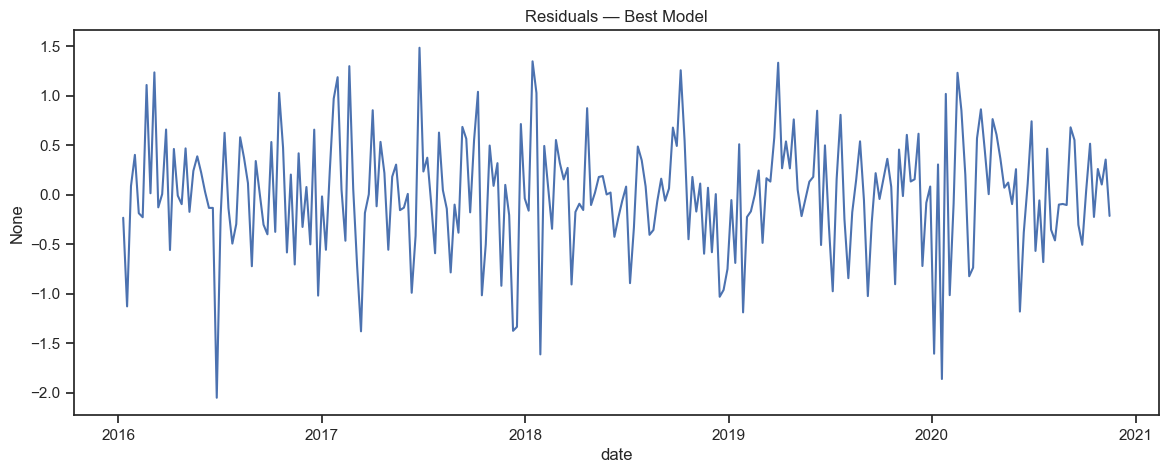

In [58]:
plt.figure(figsize=(14,5))
sns.lineplot(x=resid.index, y=resid)
plt.title("Residuals — Best Model")
plt.show()

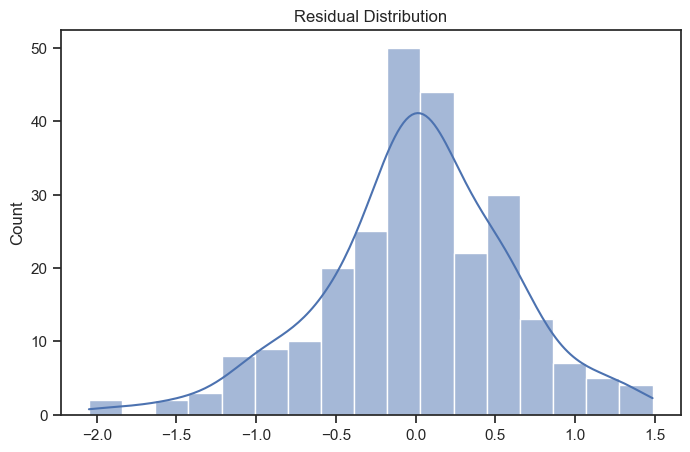

In [59]:
plt.figure(figsize=(8,5))
sns.histplot(resid, kde=True)
plt.title("Residual Distribution")
plt.show()

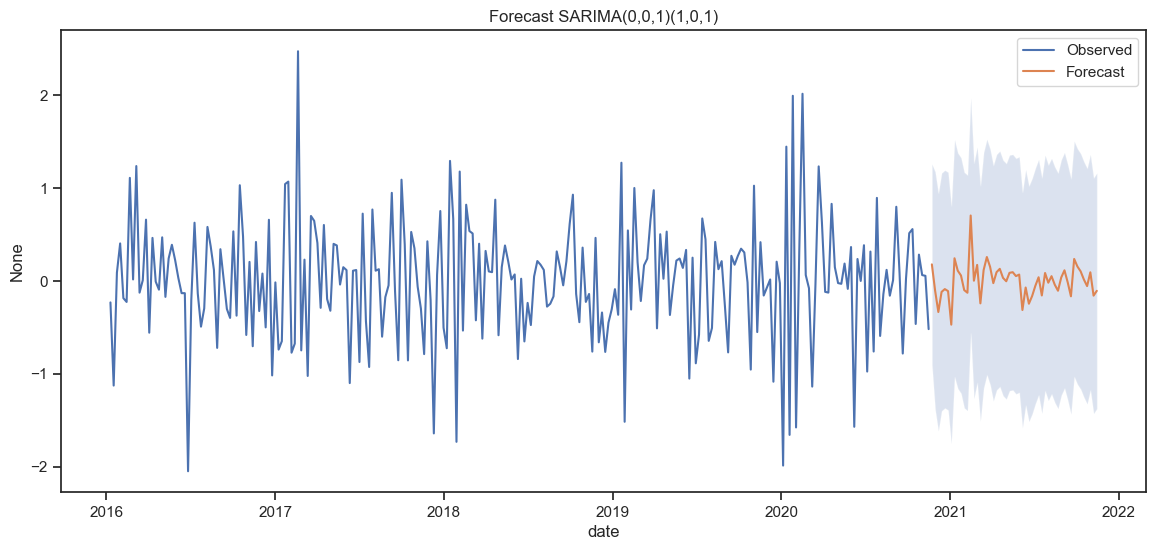

In [60]:
forecast = res.get_forecast(steps=52)

pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(14,6))

sns.lineplot(x=ts_final.index, y=ts_final, label="Observed")
sns.lineplot(x=pred_mean.index, y=pred_mean, label="Forecast")

plt.fill_between(conf_int.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 alpha=0.2)

plt.title("Forecast " + best_model["name"])
plt.legend()
plt.show()

In [61]:
def invert_differencing(forecast_diff, original_bc, d=0, D=0, s=52):

    forecast_level = forecast_diff.copy()

    if d > 0:
        last_vals = original_bc.iloc[-d:]
        forecast_level = forecast_level.cumsum() + last_vals.iloc[-1]

    if D > 0:
        seasonal_vals = original_bc.iloc[-s:]
        for i in range(len(forecast_level)):
            forecast_level.iloc[i] += seasonal_vals.iloc[i % s]

    return forecast_level

pred_bc = invert_differencing(pred_mean, ts_bc, d=best_d, D=best_D, s=52)
lower_bc = invert_differencing(conf_int.iloc[:,0], ts_bc, d=best_d, D=best_D, s=52)
upper_bc = invert_differencing(conf_int.iloc[:,1], ts_bc, d=best_d, D=best_D, s=52)

pred_original = inv_boxcox(pred_bc, lam)
lower = inv_boxcox(lower_bc, lam)
upper = inv_boxcox(upper_bc, lam)

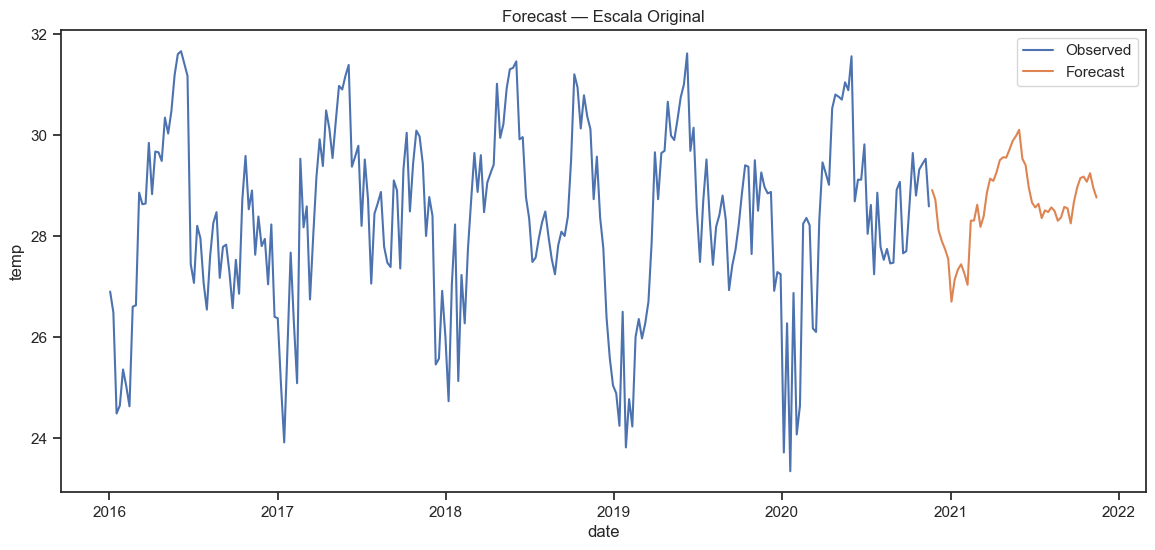

In [66]:
plt.figure(figsize=(14,6))

sns.lineplot(x=ts.index, y=ts, label="Observed")
sns.lineplot(x=pred_original.index, y=pred_original, label="Forecast")

# plt.fill_between(pred_original.index, lower, upper, alpha=0.2)
# plt.fill_between(conf_int.index,
#                  lower,
#                  upper,
#                  alpha=0.2)

plt.title("Forecast — Escala Original")
plt.legend()
plt.show()